# Investigating the correlation between chemical composition at taxonomically-related species

### Import modules

In [1]:
from collections import defaultdict
from itertools import combinations
import random

import pandas as pd
from tqdm import tqdm

# Cheminformatics
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles
from rdkit import RDLogger  
    
# Stats
from scipy.stats import mannwhitneyu
from statannot import add_stat_annotation

# Viz
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

# Import taxonomy
from utils import get_genus_and_family_info_for_plants

In [2]:
RDLogger.DisableLog('rdApp.*')

In [3]:
%matplotlib inline

In [4]:
mpl.rcParams['figure.dpi'] = 150

In [5]:
DATA_DIR = '../data/processed'

Load plant-disease evidences

In [6]:
plant_disease_df = pd.read_csv(
    f'{DATA_DIR}/plant_disease_associations.tsv',
    sep='\t',
    usecols=[
        'plant_curie',
        'disease_curie',
    ]
)

In [7]:
plant_disease_df.head(1)

,plant_curie,disease_curie
0,ncbitaxon:3369,mondo:0005324


In [8]:
medicinal_plants = set(plant_disease_df.plant_curie.unique())

In [9]:
len(medicinal_plants)

6048

Load plant-chemical evidences

In [10]:
df = pd.read_csv(
    f'{DATA_DIR}/plant_chemical_associations.tsv.zip',
    compression='zip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [11]:
df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [12]:
len(df.chemical_curie.unique())

71179

In [13]:
plant_ids = set(df.plant_curie.unique())

Get SMILES

In [14]:
smiles_df = pd.read_csv(
    '../data/mapping/smiles.tsv.zip',
    sep='\t',
    compression='zip',
)

In [15]:
smiles_df.head(1)

,pubchem id,smiles
0,pubchem:3527,CC(=CCCC1(C(CC2(C(=O)C(=C(C3=CC(=C(C=C3)O)O)O)...


In [16]:
smiles_from_pubchem_id = {}
skipped = 0

for pubchem_id, smiles in tqdm(smiles_df.values):
    
    try:
        murcko_smiles = MurckoScaffoldSmilesFromSmiles(smiles=smiles)
    except:
        skipped += 1
        continue
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
    
    smiles_from_pubchem_id[pubchem_id] = murcko_smiles


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323369/323369 [05:04<00:00, 1060.72it/s]


In [17]:
skipped, len(smiles_from_pubchem_id)

(0, 69954)

In [18]:
genus_to_species, family_to_species = get_genus_and_family_info_for_plants(plant_ids)

order genus: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16768/16768 [00:00<00:00, 23208.37it/s]


In [19]:
genus_to_species_medicinal_plants, family_to_species_medicinal_plants = get_genus_and_family_info_for_plants(
    medicinal_plants,
)

order genus: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16768/16768 [00:01<00:00, 14202.75it/s]


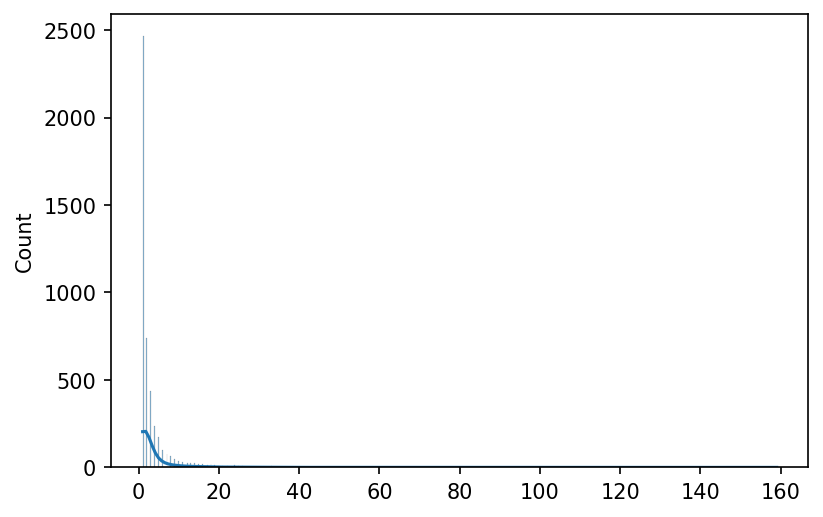

In [20]:
sns.histplot(
    [
        len(species)
        for genus, species in genus_to_species.items()
    ],
    kde=True,
)
plt.show()

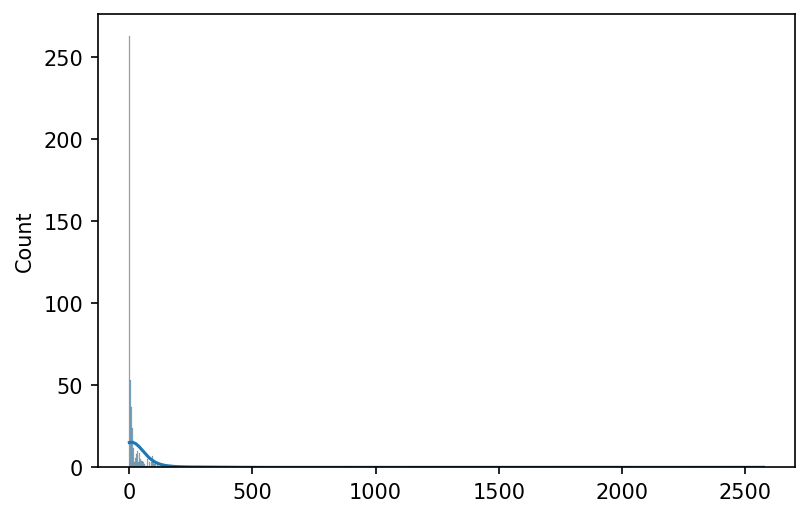

In [21]:
sns.histplot(
    [
        len(species)
        for genus, species in family_to_species.items()
    ],
    kde=True,
)
plt.show()

Prepare plant-chemicals dicts

In [22]:
plant_chem_dict = defaultdict(set)
plant_scaffolds_dict = defaultdict(set)

for plant_curie, chemical_curie in tqdm(df.values):
    
    plant_chem_dict[plant_curie].add(chemical_curie)
    
    if chemical_curie in smiles_from_pubchem_id:
        plant_scaffolds_dict[plant_curie].add(smiles_from_pubchem_id[chemical_curie])
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330655/330655 [00:00<00:00, 398345.00it/s]


In [23]:
def calculate_overlap_coefficient(plant_1, plant_2, species_to_vectors):
    """Calculate coeffiencient overlap."""
    elements_in_plant_1 = species_to_vectors[plant_1]
    elements_in_plant_2 = species_to_vectors[plant_2]
    
    if not elements_in_plant_1 or not elements_in_plant_2:
        return 0
    
    return len(
        elements_in_plant_1.intersection(elements_in_plant_2)
    ) / min([len(elements_in_plant_1), len(elements_in_plant_2)])

def calculate_overlap_for_taxa_level(
    taxonomy_dict,
    species_to_chemicals_dict,
    pair_type,
    species_to_scaffold_dict,
):
    similarity_list = []
    skipped = 0
    
    for _, species in tqdm(
        taxonomy_dict.items(),
        desc='calculating similarity...',
        total=len(taxonomy_dict),
    ):
        # Not enough species to calculate similarity
        if len(species) <= 1:
            skipped += 1
            continue
                        
        for plant_1, plant_2 in combinations(species, 2):
            
            if plant_1 not in species_to_chemicals_dict or plant_2 not in species_to_chemicals_dict:
                continue
            
            # Original chemicals
            overlap_coefficient = calculate_overlap_coefficient(plant_1, plant_2, species_to_chemicals_dict)
            # Scaffolds
            overlap_coefficient_scaffolds = calculate_overlap_coefficient(
                plant_1, plant_2, species_to_scaffold_dict
            )
            
            similarity_list.append({
                'plant_1': plant_1,
                'plant_2': plant_2,
                'pair_type': pair_type,
                'overlap_coefficient': overlap_coefficient,
                'overlap_coefficient_scaffolds': overlap_coefficient_scaffolds,
            })    
            
    return pd.DataFrame(similarity_list)


def calculate_baseline_overlap(
    all_plants,
    family_taxonomy,
    species_to_chemicals_dict,
    species_to_scaffold_dict,
):
    """Calculate overlap (disease/chemical) for plants ensuring that they are not 
    belonging to the same family (taxonomically-related)."""
    
    # List to store the similarity/overlap for these non-taxonomically plants
    similarity_list = []
        
    species_to_family = {
        plant: family
        for family, species in family_taxonomy.items()
        for plant in species
    }
    
    outdated_ids = set()
    
    # Ensure it is a list
    all_plants = list(all_plants)
    
    while len(similarity_list) < 100000:
        # Get two random plants
        plant_1, plant_2 = random.choices(all_plants, k=2)
        
        # Plants with a wrong identifier
        if plant_1 not in species_to_family:
            outdated_ids.add(plant_1)
            continue
            
        if plant_2 not in species_to_family:
            outdated_ids.add(plant_2)
            continue
                
        # Skip if the plants belong to the same family
        if species_to_family[plant_1] == species_to_family[plant_2]:
            continue

        # Original chemicals
        overlap_coefficient = calculate_overlap_coefficient(plant_1, plant_2, species_to_chemicals_dict)
        # Scaffolds
        overlap_coefficient_scaffolds = calculate_overlap_coefficient(plant_1, plant_2, species_to_scaffold_dict)
            

        similarity_list.append({
            'plant_1': plant_1,
            'plant_2': plant_2,
            'pair_type': 'Random',
            'overlap_coefficient': overlap_coefficient,
            'overlap_coefficient_scaffolds': overlap_coefficient_scaffolds,
        })
            
    return pd.DataFrame(similarity_list), outdated_ids

Calculate chemical similarity for plants in the same genus or family

In [24]:
genus_similarity = calculate_overlap_for_taxa_level(
    taxonomy_dict=genus_to_species, # genus to species
    species_to_chemicals_dict=plant_chem_dict, # plant(s) -> chemical ids
    species_to_scaffold_dict=plant_scaffolds_dict,
    pair_type='Same genus',
)

family_similarity = calculate_overlap_for_taxa_level(
    taxonomy_dict=family_to_species, # family to species
    species_to_chemicals_dict=plant_chem_dict, # plant(s) -> chemical ids
    species_to_scaffold_dict=plant_scaffolds_dict,
    pair_type='Same family'
)

calculating similarity...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:23<00:00, 21.51it/s]


Calculate chemical similarity for non taxonomically related plants

In [25]:
baseline_similarity, outdated_ids = calculate_baseline_overlap(
    all_plants=plant_ids,
    family_taxonomy=family_to_species,  # family to species
    species_to_chemicals_dict=plant_chem_dict, # plant(s) -> chemical ids
    species_to_scaffold_dict=plant_scaffolds_dict,
)

In [26]:
len(outdated_ids)

59

In [27]:
merged_df = pd.concat([
    genus_similarity,
    family_similarity,
    baseline_similarity,
])

Visualization config

In [28]:
sns.set(context='poster')
mpl.rcParams['figure.dpi'] = 400

### All plants in COCONUT/LOTUS 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Same genus v.s. Same family: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=7.490e+11
Same family v.s. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.883e-118 U_stat=3.412e+11
Chemical similarity for Same genus - mean: 0.146, median: 0.000
Chemical similarity for Same family - mean: 0.030, median: 0.000
Chemical similarity for Random - mean: 0.011, median: 0.000



***** Scaffolds ******
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Same genus v.s. Same family: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=7.625e+11
Same family v.s. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni c

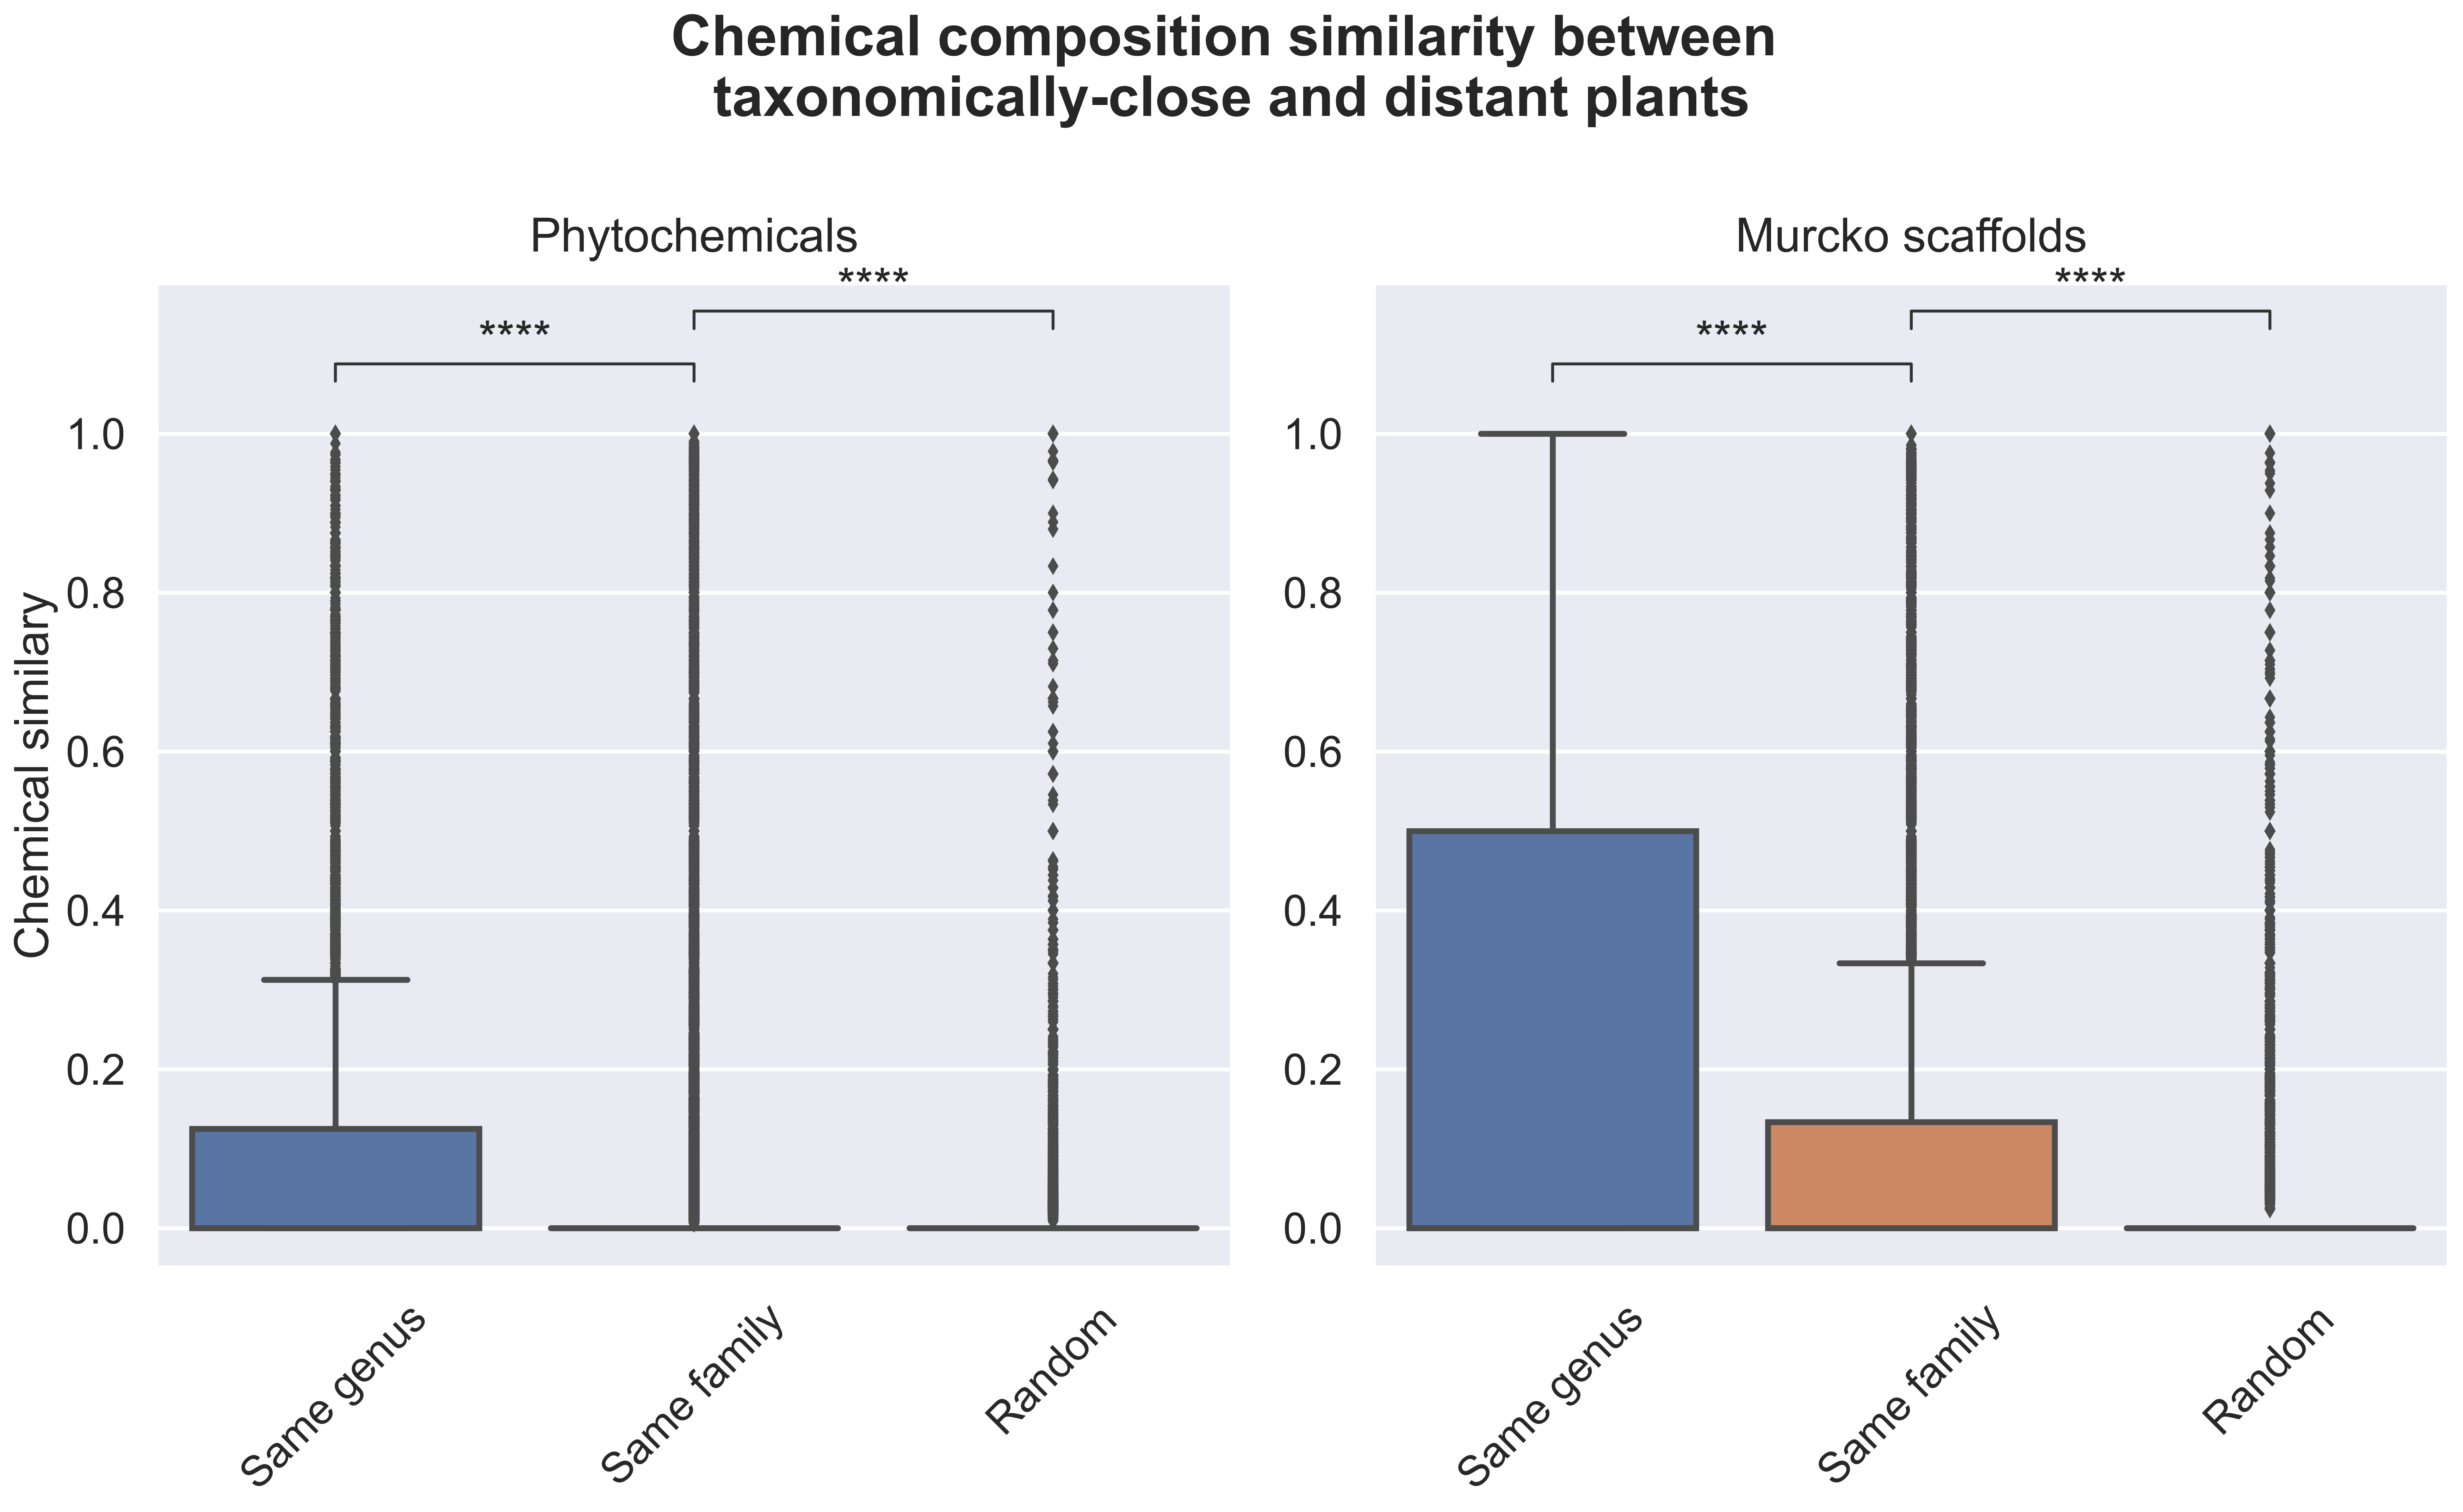

In [29]:
fig = plt.figure(figsize=(18, 11)) 

ax1 = plt.subplot2grid(shape=(1,2), loc=(0,0), colspan=1)
ax2 = plt.subplot2grid((1,2), (0,1), colspan=1)

suptitle = plt.suptitle(
    'Chemical composition similarity between \ntaxonomically-close and distant plants',
    y=0.99,
    fontweight='bold'
)

sns.boxplot(data=merged_df, x='pair_type', y='overlap_coefficient', ax=ax1)
add_stat_annotation(
    data=merged_df,
    x='pair_type',
    y='overlap_coefficient',
    ax=ax1,
    box_pairs=[
       ("Same genus", "Same family"), 
       ("Same family", "Random")
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax1.xaxis.set_tick_params(rotation=45)

# Avoids that 1.2 comes in the plot
ax1.set_ylim([-0.05, 1.19])

# Set Y and X ticks
ax1.set_ylabel("Chemical similary")
ax1.set_xlabel("")
ax1.set_title("Phytochemicals", y=1.02)

for col in merged_df.pair_type.unique():
    info = merged_df[merged_df.pair_type == col]
    print(
        f'Chemical similarity for {col} - mean: {info["overlap_coefficient"].mean():.3f}, median: {info["overlap_coefficient"].median():.3f}'
    )


print('\n\n')
print("""***** Scaffolds ******""")

sns.boxplot(data=merged_df, x='pair_type', y='overlap_coefficient_scaffolds', ax=ax2)
add_stat_annotation(
    data=merged_df,
    x='pair_type',
    y='overlap_coefficient_scaffolds',
    ax=ax2,
    box_pairs=[
       ("Same genus", "Same family"), 
       ("Same family", "Random")
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax2.xaxis.set_tick_params(rotation=45)

# Avoids that 1.2 comes in the plot
ax2.set_ylim([-0.05, 1.19])

# Set Y and X ticks
ax2.set_ylabel("")
ax2.set_xlabel("")

ax2.set_title("Murcko scaffolds", y=1.02)

for col in merged_df.pair_type.unique():
    info = merged_df[merged_df.pair_type == col]
    print(
        f'Chemical similarity for {col} - mean: {info["overlap_coefficient_scaffolds"].mean():.3f}, median: {info["overlap_coefficient_scaffolds"].median():.3f}'
    )
    
plt.tight_layout()
plt.savefig(
    f'../data/figures/figure_4_all_plants.png',
    dpi=400,
    bbox_inches='tight', 
    bbox_extra_artists=[suptitle],
)
plt.show()

### Reduce the analysis to medicinal plants

In [30]:
# Same code as above but only filtering out non medicinal plants
medicinal_plants_to_chemicals = {
    plant: chemicals
    for plant, chemicals in plant_chem_dict.items()
    if plant in medicinal_plants
}

genus_similarity_medicinal_plants = calculate_overlap_for_taxa_level(
    taxonomy_dict=genus_to_species_medicinal_plants, # genus to species
    species_to_chemicals_dict=medicinal_plants_to_chemicals, # note that we only pass now medicinal plants
    species_to_scaffold_dict=plant_scaffolds_dict,
    pair_type='Same genus',
)

# Same code as above but only filtering out non medicinal plants

family_similarity_medicinal_plants = calculate_overlap_for_taxa_level(
    taxonomy_dict=family_to_species_medicinal_plants, # family to species
    species_to_chemicals_dict=medicinal_plants_to_chemicals, # note that we only pass now medicinal plants    
    species_to_scaffold_dict=plant_scaffolds_dict,
    pair_type='Same family'
)

baseline_similarity_medicinal_plants, outdated_ids = calculate_baseline_overlap(
    all_plants={
        plant
        for plant in plant_ids
        if plant in medicinal_plants and plant in medicinal_plants_to_chemicals
    },
    family_taxonomy=family_to_species,  # family to species
    species_to_chemicals_dict=medicinal_plants_to_chemicals, # note that we only pass now medicinal plants    
    species_to_scaffold_dict=plant_scaffolds_dict,
)

merged_medicinal_plants_df = pd.concat([
    genus_similarity_medicinal_plants,
    family_similarity_medicinal_plants,
    baseline_similarity_medicinal_plants,
])

calculating similarity...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 356/356 [00:00<00:00, 453.74it/s]


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Same genus v.s. Same family: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=1.384e+09
Same family v.s. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=1.165e+10
Chemical similarity for Same genus - mean: 0.167, median: 0.026
Chemical similarity for Same family - mean: 0.053, median: 0.000
Chemical similarity for Random - mean: 0.024, median: 0.000



***** Scaffolds ******
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Same genus v.s. Same family: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=1.355e+09
Same family v.s. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni co

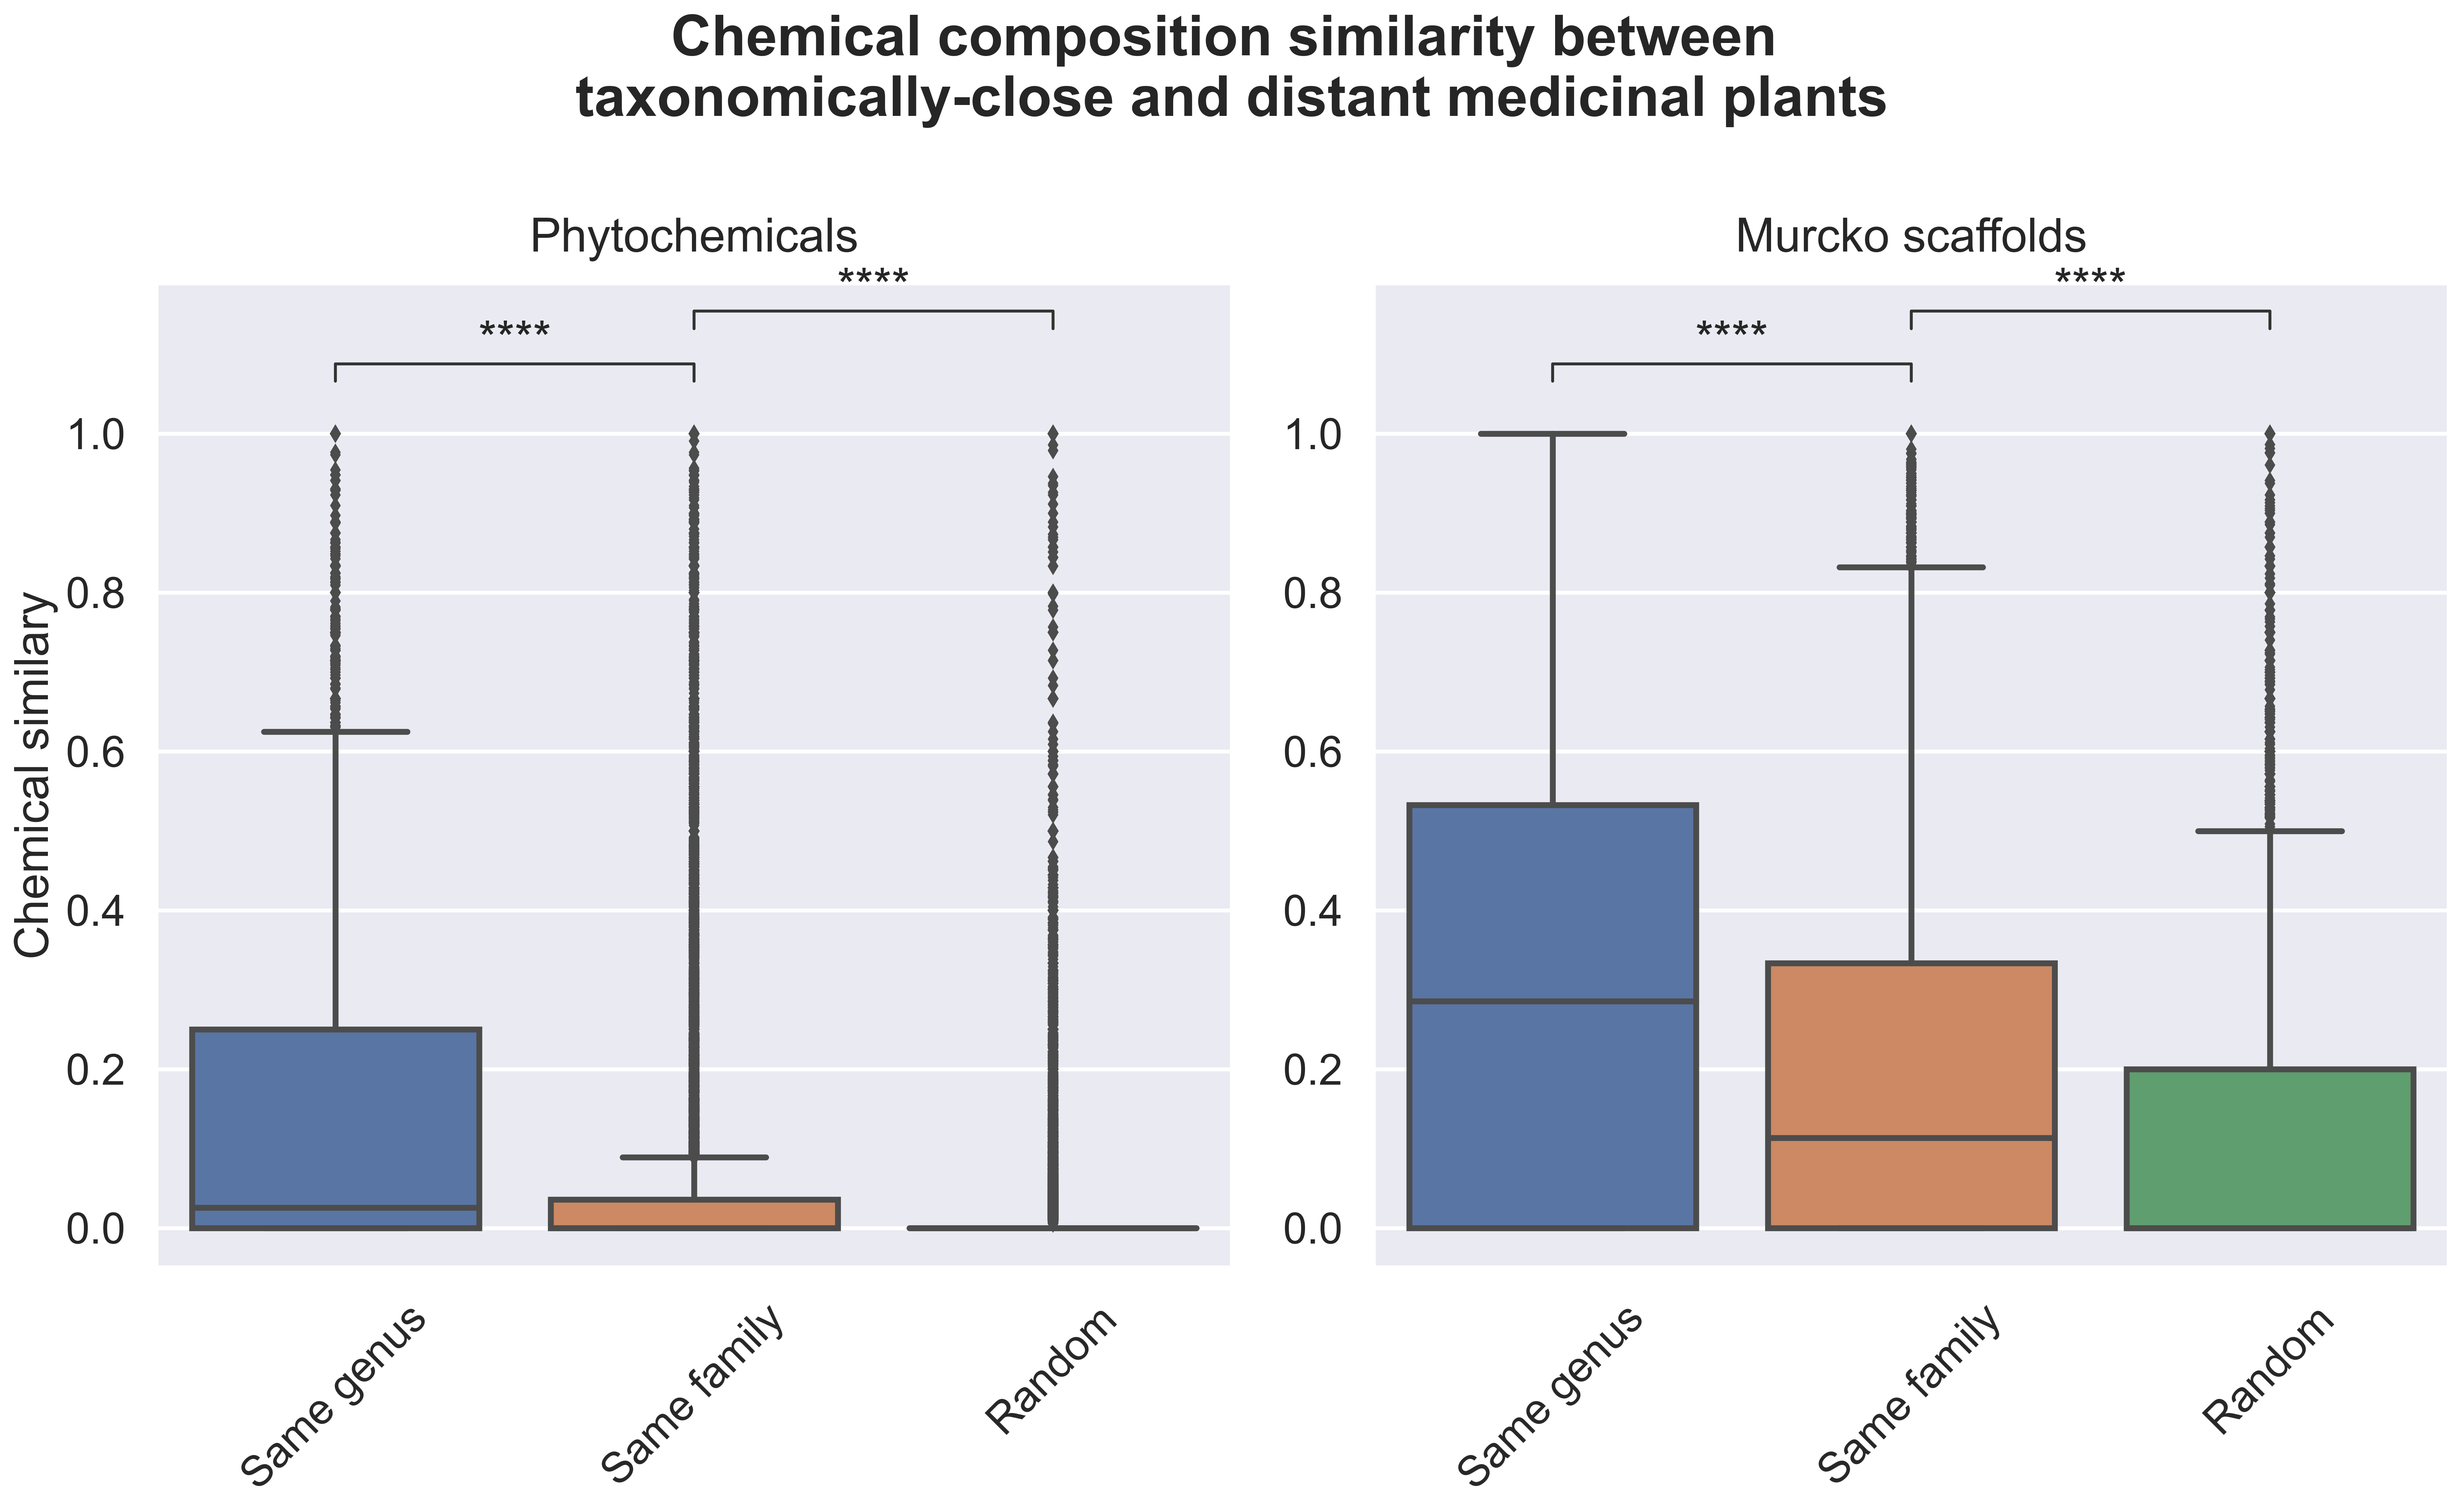

In [31]:
fig = plt.figure(figsize=(18, 11)) 

ax1 = plt.subplot2grid(shape=(1,2), loc=(0,0), colspan=1)
ax2 = plt.subplot2grid((1,2), (0,1), colspan=1)

suptitle = plt.suptitle(
    'Chemical composition similarity between \ntaxonomically-close and distant medicinal plants',
    y=0.99,
    fontweight='bold'
)

sns.boxplot(data=merged_medicinal_plants_df, x='pair_type', y='overlap_coefficient', ax=ax1)
add_stat_annotation(
    data=merged_medicinal_plants_df,
    x='pair_type',
    y='overlap_coefficient',
    ax=ax1,
    box_pairs=[
       ("Same genus", "Same family"), 
       ("Same family", "Random")
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax1.xaxis.set_tick_params(rotation=45)

# Avoids that 1.2 comes in the plot
ax1.set_ylim([-0.05, 1.19])

# Set Y and X ticks
ax1.set_ylabel("Chemical similary")
ax1.set_xlabel("")

ax1.set_title("Phytochemicals", y=1.02)

for col in merged_medicinal_plants_df.pair_type.unique():
    info = merged_medicinal_plants_df[merged_medicinal_plants_df.pair_type == col]
    print(
        f'Chemical similarity for {col} - mean: {info["overlap_coefficient"].mean():.3f}, median: {info["overlap_coefficient"].median():.3f}'
    )


print('\n\n')
print("""***** Scaffolds ******""")

sns.boxplot(data=merged_medicinal_plants_df, x='pair_type', y='overlap_coefficient_scaffolds', ax=ax2)
add_stat_annotation(
    data=merged_medicinal_plants_df,
    x='pair_type',
    y='overlap_coefficient_scaffolds',
    ax=ax2,
    box_pairs=[
       ("Same genus", "Same family"), 
       ("Same family", "Random")
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax2.xaxis.set_tick_params(rotation=45)

# Avoids that 1.2 comes in the plot
ax2.set_ylim([-0.05, 1.19])

# Set Y and X ticks
ax2.set_ylabel("")
ax2.set_xlabel("")

ax2.set_title("Murcko scaffolds", y=1.02)

for col in merged_medicinal_plants_df.pair_type.unique():
    info = merged_medicinal_plants_df[merged_medicinal_plants_df.pair_type == col]
    print(
        f'Chemical similarity for {col} - mean: {info["overlap_coefficient_scaffolds"].mean():.3f}, median: {info["overlap_coefficient_scaffolds"].median():.3f}'
    )
    
plt.tight_layout()
plt.savefig(
    f'../data/figures/figure_4_medicinal_plants.png',
    dpi=400,
    bbox_inches='tight', 
    bbox_extra_artists=[suptitle],
)
plt.show()